In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import sklearn.cluster as cluster
from sklearn.metrics import pairwise_distances_argmin_min
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.cluster import DBSCAN
 
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

In [2]:
sharing_url = "https://drive.google.com/file/d/1zLs02TTxbt1Htk1RdIJM5AaBacs6Y39K/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

data = pd.read_csv(download_url)

In [3]:
data

,Title,URL,Question,Categories
0,your browser version is not supported using sy...,https://stackoverflow.com/questions/76981459/y...,I'm trying to automate some features and I nee...,"['php', 'symfony', 'web-scraping']"
1,how to get button text value in java,https://stackoverflow.com/questions/76981456/h...,I want to get button text value to do the on c...,"['java', 'button']"
2,How to make sure communication is stable when ...,https://stackoverflow.com/questions/76981455/h...,This is my Node codeasync function runClient()...,"['javascript', 'node.js', 'go', 'zeromq']"
3,Cubical Agda Inclusion Order,https://stackoverflow.com/questions/76981453/c...,I'm almost finished defining an Inclusion Orde...,['agda']
4,How to convert depth map to image(.png) format...,https://stackoverflow.com/questions/76981450/h...,I am using a depth camera which captures a 500...,"['3d', 'computer-vision', 'point-clouds', 'vis..."
...,...,...,...,...
22118,SqlAzureDacpacDeployment@1 - parameter problem,https://stackoverflow.com/questions/76933724/s...,I have the following devops task in my pipelin...,"['powershell', 'azure-devops']"
22119,How do I instantiate structs inside a nested c...,https://stackoverflow.com/questions/76933723/h...,So I googled everywhere and cannot get a strai...,"['c++', 'struct', 'nested', 'inner-classes']"
22120,How to reverse_lazy user in template view's ge...,https://stackoverflow.com/questions/76933722/h...,Does anyone know how I can redirect the user t...,"['django', 'django-models', 'django-views', 'd..."
22121,"""undefined reference to `GOACC_parallel_keyed'...",https://stackoverflow.com/questions/76933719/u...,I am working on a project where I have to opti...,"['fortran', 'linker-errors', 'openacc']"


# CountVectorizer

In [4]:
vectorizer_CountVectorizer = CountVectorizer()
questions_CountVectorizer = vectorizer_CountVectorizer.fit_transform(data['Question'])

# TfidfVectorizer

In [5]:
vectorizer_TfidfVectorizer = TfidfVectorizer()
questions_TfidfVectorizer = vectorizer_TfidfVectorizer.fit_transform(data['Question'])

### TF-IDF — статистический показатель, применяемый для оценки важности слова в контексте коллекции документов

TF - частота слова в документе \
IDF - обратная частота документов, в котором появляется слово на общее количество документов

Расчет формулы TF-IDF: 

$$
TF-IDF = TF * IDF
$$

$$
TF = \frac {n_t} {\sum _ { i = 1 } ^ { m } n_i} 
$$

где числитель -  количество отдельных слов в документе, знаменатель  - общее количество всех слов в документе

$$
IDF = \ln (\frac {n_c} {\sum _ { j = 1 } ^ { m } n_j} )
$$

где числитель -  общее количество документов, знаменатель  - количестводокументов в которых содержится интересующее слово

более подробно: https://wiki.loginom.ru/articles/tf-idf.html

# GLOVE

In [6]:
# Путь к файлу GloVe
glove_file = 'glove.6B.100d.txt'  # пример файла
word2vec_output_file = 'glove.6B.100d.word2vec'

# конвертация файла GloVe в формат, совместимый с gensim
glove2word2vec(glove_file, word2vec_output_file)

# Загрузка модели
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

C:\Users\Frigen\AppData\Local\Temp\ipykernel_15052\1032933487.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_output_file)


In [7]:
def text_to_vector(text):
    words = text.split()
    word_vectors = []
    for word in words:
        try:
            word_vector = model[word]
            word_vectors.append(word_vector)
        except KeyError:
            # Если слова нет в словаре, мы его пропускаем
            pass
    
    # Усредняем векторы слов
    if len(word_vectors) > 0:
        text_vector = np.mean(word_vectors, axis=0)
    else:
        # Если все слова отсутствуют в словаре, возвращаем нулевой вектор
        text_vector = np.zeros(model.vector_size)

    return text_vector

questions_glove = np.stack(data['Question'].apply(lambda x: text_to_vector(x)))

# CountVectorizer clusters

In [22]:
inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(questions_CountVectorizer) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров

100%|██████████| 18/18 [13:20<00:00, 44.46s/it]


In [23]:
for i in inertia:
    print(i)

38233009.42450976
36249153.0363041
35184108.90815255
34149105.709167525
33208582.148358934
32506875.46920192
32098385.88545591
31273466.731305927
30524106.26223739
30413830.721738607
29980155.791140214
29407058.60518626
29020976.493499205
28548496.958069596
29276980.556086384
28446174.734437205
28165142.042266656
28195518.103184085


In [24]:
silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(questions_CountVectorizer)

    silhouette[i] = silhouette_score(questions_CountVectorizer, kmeans.labels_, metric='euclidean')

100%|██████████| 18/18 [21:18<00:00, 71.01s/it] 


In [25]:
print(silhouette)

{2: 0.9781639752216551, 3: 0.9113356911465459, 4: 0.4314978346440937, 5: 0.42977275315104685, 6: 0.41941997301698286, 7: 0.414813639329965, 8: 0.41316629655498627, 9: 0.3806087044386178, 10: 0.4055787863389779, 11: 0.3886347976293754, 12: 0.3724626493865604, 13: 0.19756942408340664, 14: 0.16995085750359643, 15: 0.17238545886577447, 16: 0.1358576940823577, 17: 0.18882978851801394, 18: 0.1796141718158156, 19: 0.15090191958469792}


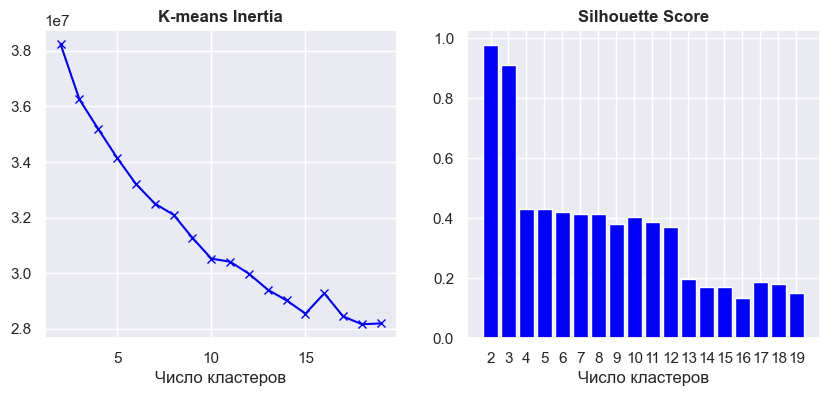

In [26]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

# 2 кластера подходит больше всего

In [ ]:
kmeans = cluster.KMeans(n_clusters=2,random_state=17, init='k-means++')

kmeans_labels = kmeans.fit_predict(questions_CountVectorizer)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

0    22122
1        1
Name: count, dtype: int64

In [ ]:
nearest_indices, nearest_distances = pairwise_distances_argmin_min(centroids, questions_CountVectorizer)

# for i, nearest_index in enumerate(nearest_indices):
#     print(f"Centroid {i}: Data point index {nearest_index}, Distance: {nearest_distances[i]}")

nearest_texts = [data['Question'].iloc[i] for i in nearest_indices]

for i, nearest_text in enumerate(nearest_texts):
    print(f"Centroid {i} nearest text: {nearest_text}")


Centroid 0 nearest text: Here is the image of the error:What is the solution to this error? I tried to write here the 'Row" function but the emulator is not opening the application.
Centroid 1 nearest text: I want to find the mean (for numerical variables) and mode (for character variables) for each of the variables under column "trait_name" for each unique "taxon_name". I would then like to tabulate these values.This is what my dataframe looks like currently (I also have a wide version):This is my desired output:I've written code that manually calculates the mean and mode for each "trait_name" per "taxon_name" as follows:# create mode functionfind.mode <- function(x, na.rm = TRUE) {    if(na.rm){     x = x[!is.na(x)]  }    val <- unique(x)  return(val[which.max(tabulate(match(x, val)))])}# MEAN AND MODE OF TRAITS## Acacia implexa acacia_mass <- mean(species_traits_wide$seed_dry_mass[species_traits_wide$taxon_name == "Acacia implexa"], na.rm = TRUE)acacia_length <- mean(species_traits_

## Кажется, что сложно в данном случае описать кластеры 

# TfidfVectorizer clusters

100%|██████████| 18/18 [28:20<00:00, 94.48s/it] 


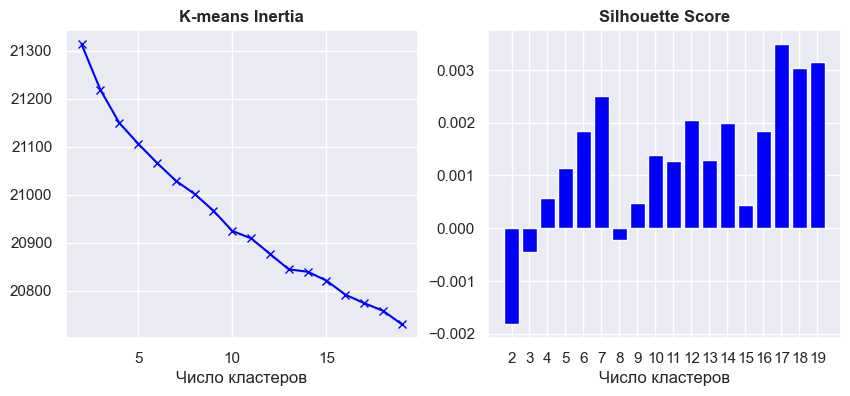

In [28]:
inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(questions_TfidfVectorizer) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров

silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(questions_TfidfVectorizer)

    silhouette[i] = silhouette_score(questions_TfidfVectorizer, kmeans.labels_, metric='euclidean')

sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

# Кажется, что тут лучше всего будет 17 кластеров, но значение силуэта очень маленькое все равно

In [59]:
kmeans = cluster.KMeans(n_clusters=17,random_state=17, init='k-means++')

kmeans_labels = kmeans.fit_predict(questions_TfidfVectorizer)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0     6978
3     3986
10    2058
1     1149
15    1080
8      998
16     950
4      914
11     895
9      534
6      507
7      415
14     393
2      373
12     307
5      304
13     282
Name: count, dtype: int64

In [60]:
nearest_indices, nearest_distances = pairwise_distances_argmin_min(centroids, questions_TfidfVectorizer)

# for i, nearest_index in enumerate(nearest_indices):
#     print(f"Centroid {i}: Data point index {nearest_index}, Distance: {nearest_distances[i]}")

nearest_texts = [data['Question'].iloc[i] for i in nearest_indices]

for i, nearest_text in enumerate(nearest_texts):
    print(f"Centroid {i} nearest text: {nearest_text}")


Centroid 0 nearest text: I have a treeview in Python GTK2 with custom colors set (only one in the attached images so far but will be more in time) and also a custom color set for the line selected, but my issue is when I select and toggle my first cell so I can edit the data in the line and then select a cell in that line to edit the system reverts back to the system settings as per attached images: Selected Line color, Editing Cell colorI'm just wondering if anyone here knows how to access this part of the treeview so I can set the colors how I would like, and if anyone does could they share how to do this or point me in where to find the info I require.Also another issue I have which is not a major is the color of the inside of check boxes is white, interested to know if there is a way to change this as well.I know for both of these issues I could just set a custom system appearance but I would like to leave the system as it is and just modify these things in the program I am buildin

# GLOVE clusters

100%|██████████| 18/18 [02:32<00:00,  8.49s/it]


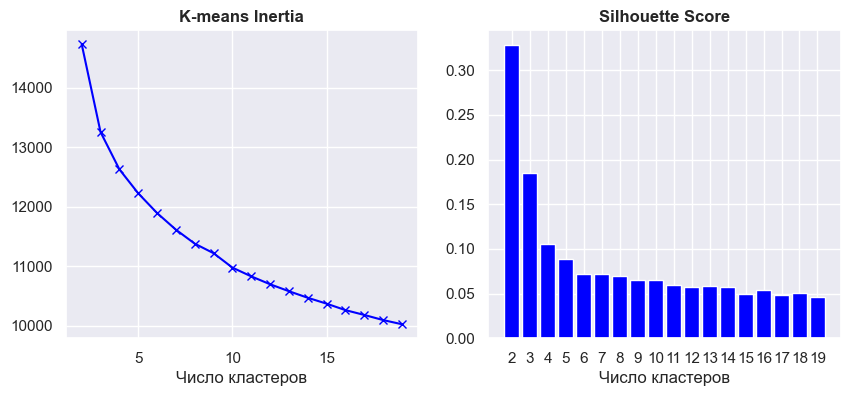

In [40]:
inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(questions_glove) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров


silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(questions_glove)

    silhouette[i] = silhouette_score(questions_glove, kmeans.labels_, metric='euclidean')

sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

# Возьмем 2 кластера

In [61]:
kmeans = cluster.KMeans(n_clusters=2,random_state=17, init='k-means++')

kmeans_labels = kmeans.fit_predict(questions_glove)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    16272
1     5851
Name: count, dtype: int64

In [63]:
nearest_indices, nearest_distances = pairwise_distances_argmin_min(centroids, questions_glove)

# for i, nearest_index in enumerate(nearest_indices):
#     print(f"Centroid {i}: Data point index {nearest_index}, Distance: {nearest_distances[i]}")

nearest_texts = [data['Question'].iloc[i] for i in nearest_indices]

for i, nearest_text in enumerate(nearest_texts):
    print(f"Centroid {i} nearest text: {nearest_text}")


Centroid 0 nearest text: Preface: I know this is an extremely common question. I've read about two dozen of these and tried all the proposed solutions, but just can't get it to work on my site. There are no other WordPress devs in my shop and I need more eyes on the code.I am writing a custom WordPress block and need to be able to be able to rewrite URLs for SEO reasons. Specifically, when a browser hits a URL like:mydomain.edu/url-rewrite-tester-post/foovarthe content that is served should be as if the URL were:mydomain.edu/url-rewrite-tester-post?URLvar=foovarMore specifically, taking into account that the rewrite will not encounter certain default redirect rules to assume the index page, the rewrite should serve:mydomain.edu/index.php?pagename=url-rewrite-tester-post&URLvar=foovarIMPORTANT NOTE: The site's permalink structure is set to 'post name'. I've been able to get code of this kind working with a 'plain' permalink structure, but not with the 'post name' permalink structure in 

# Здесь похоже, что кластеры поделились на открытые и закрытые

# Предобработаем тексты

In [14]:
def filter_text(text):
    stopWords = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    words=[word.lower() for word in words if word.isalpha()]
    words = [w for w in words if w not in stopWords]
    return ' '.join([lemmatizer.lemmatize(lemma) for lemma in words])

data_lemma = data['Question'].apply(lambda x: filter_text(x))
data_lemma

0        trying automate feature need scarp web using b...
1        want get button text value click command ca fi...
2        node codeasync function runclient hello world ...
3        almost finished defining inclusion order cubic...
4        using depth camera capture depth map meter als...
                               ...                        
22118    following devops task pipeline task sqlazureda...
22119    googled everywhere get straight answer problem...
22120    anyone know redirect user another link using r...
22121    working project optimise performance computati...
22122    closed question seeking recommendation book to...
Name: Question, Length: 22123, dtype: object

# Пробуем тоже самое еще раз

# CountVectorizer clusters

100%|██████████| 18/18 [10:29<00:00, 34.99s/it]


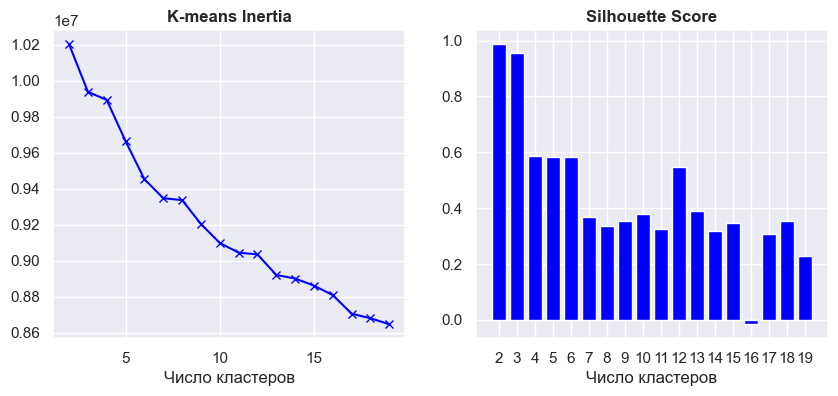

In [16]:
vectorizer_CountVectorizer = CountVectorizer()
questions_CountVectorizer = vectorizer_CountVectorizer.fit_transform(data_lemma)

inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(questions_CountVectorizer) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров

# все как в предыдущей ячейке, только силуэт-скоры сохраняем как значения в словаре
silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(questions_CountVectorizer)

    silhouette[i] = silhouette_score(questions_CountVectorizer, kmeans.labels_, metric='euclidean')

sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

# Возьму 3 кластера, т.к. в прошлый раз (когда было 2 кластеры), они поделилсь 99.9% данных в одном и всего 1 пример в другом

In [23]:
kmeans = cluster.KMeans(n_clusters=3,random_state=17, init='k-means++')

kmeans_labels = kmeans.fit_predict(questions_CountVectorizer)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

nearest_indices, nearest_distances = pairwise_distances_argmin_min(centroids, questions_CountVectorizer)
nearest_texts = [data['Question'].iloc[i] for i in nearest_indices]

for i, nearest_text in enumerate(nearest_texts):
    print(f"Centroid {i} nearest text: {nearest_text}")


0    22121
2        1
1        1
Name: count, dtype: int64

Centroid 0 nearest text: Is there a difference between ++x and x++ in java?
Centroid 1 nearest text: I want to find the mean (for numerical variables) and mode (for character variables) for each of the variables under column "trait_name" for each unique "taxon_name". I would then like to tabulate these values.This is what my dataframe looks like currently (I also have a wide version):This is my desired output:I've written code that manually calculates the mean and mode for each "trait_name" per "taxon_name" as follows:# create mode functionfind.mode <- function(x, na.rm = TRUE) {    if(na.rm){     x = x[!is.na(x)]  }    val <- unique(x)  return(val[which.max(tabulate(match(x, val)))])}# MEAN AND MODE OF TRAITS## Acacia implexa acacia_mass <- mean(species_traits_wide$seed_dry_mass[species_traits_wide$taxon_name == "Acacia implexa"], na.rm = TRUE)acacia_length <- mean(species_traits_wide$seed_length[species_traits_wide$taxon_name == "Acacia implexa"], na.rm = TRUE)acacia_form <- find.mod

# TfidfVectorizer clusters

100%|██████████| 18/18 [12:26<00:00, 41.48s/it]


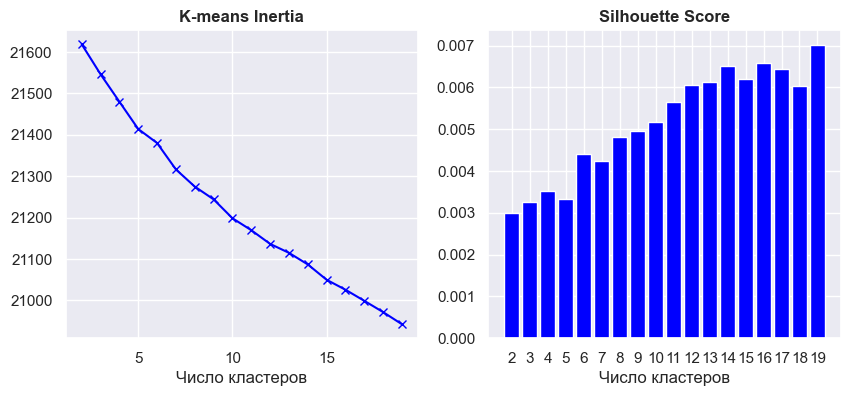

In [17]:
vectorizer_TfidfVectorizer = TfidfVectorizer()
questions_TfidfVectorizer = vectorizer_TfidfVectorizer.fit_transform(data_lemma)


inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(questions_TfidfVectorizer) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров

silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(questions_TfidfVectorizer)

    silhouette[i] = silhouette_score(questions_TfidfVectorizer, kmeans.labels_, metric='euclidean')

sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

# Снова очень маленькое значение силуэта, возьмем 19 кластеров

In [25]:
kmeans = cluster.KMeans(n_clusters=19,random_state=17, init='k-means++')

kmeans_labels = kmeans.fit_predict(questions_TfidfVectorizer)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

nearest_indices, nearest_distances = pairwise_distances_argmin_min(centroids, questions_TfidfVectorizer)
nearest_texts = [data['Question'].iloc[i] for i in nearest_indices]

for i, nearest_text in enumerate(nearest_texts):
    print(f"Centroid {i} nearest text: {nearest_text}")


c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3     7633
17    2548
8     2240
7      967
14     964
6      959
10     938
12     808
16     769
4      732
11     593
13     551
9      515
5      503
18     407
1      307
2      291
15     206
0      192
Name: count, dtype: int64

Centroid 0 nearest text: I want to show a data string from firebase firestore in my flutter app. This should be an info text. I want that this text gets realtime updated. My problem is with this code that i'm getting this error:StateError (Bad state: field does not exist within the DocumentSnapshotPlatform)I've searched trough the entire internet but i haven't found any solutions for this... i hope someone can help me .. here whole code if i miss or somethingjob_screen.dart// ignore_for_file: use_key_in_widget_constructors, unused_import, sized_box_for_whitespace, avoid_print, unused_fieldimport 'package:cloud_firestore/cloud_firestore.dart';import 'package:firebase_auth/firebase_auth.dart';import 'package:firebase_core/firebase_core.dart';import 'package:flutter/material.dart';import 'package:job_app/Jobs/search_job.dart';import 'package:job_app/Search/search_screen.dart';import 'package:job_app/Widgets/bottom_nav_bar.dart';import 'package:job_app/Widgets/job_widget.dart';import 'pack

# GLOVE clusters

100%|██████████| 18/18 [02:33<00:00,  8.53s/it]


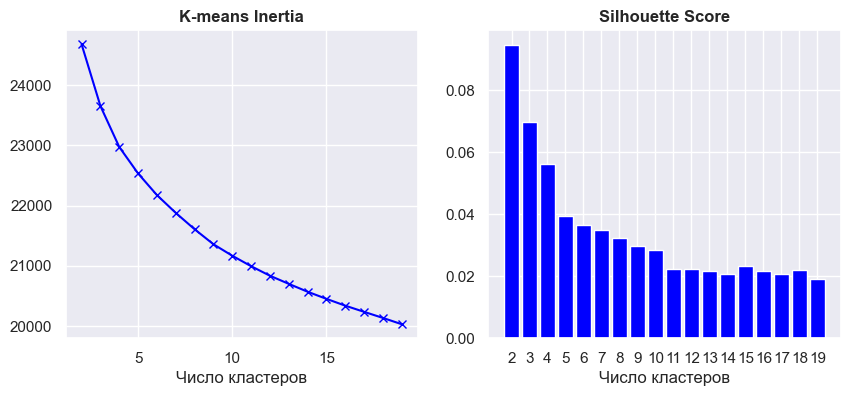

In [18]:
questions_glove = np.stack(data_lemma.apply(lambda x: text_to_vector(x)))

inertia = []
for i in tqdm(range(2,20)): # значения интервала - число кластеров (можно изменять)

    kmeans = cluster.KMeans(
               n_clusters=i, # инициализируем модель
               init='k-means++', # метод, как разбросать центры среди данных
               n_init=15, # сколько раз будем переопределять центры (в результате выберем самый успешный)
               max_iter=500, # количество итераций а один проход алгоритма
               random_state=17 # сколько раз датасет перемешан перед кластеризацией
    )


    kmeans.fit(questions_glove) # обучаем модель
    inertia.append(kmeans.inertia_) # добавляем значения инерции для каждого числа кластеров


silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(questions_glove)

    silhouette[i] = silhouette_score(questions_glove, kmeans.labels_, metric='euclidean')

sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')
# первый параметр = x (число шагов= числу кластеров), второй = y (инерция)

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

# 2 кластера 

In [26]:
kmeans = cluster.KMeans(n_clusters=2,random_state=17, init='k-means++')

kmeans_labels = kmeans.fit_predict(questions_glove)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

nearest_indices, nearest_distances = pairwise_distances_argmin_min(centroids, questions_glove)
nearest_texts = [data['Question'].iloc[i] for i in nearest_indices]

for i, nearest_text in enumerate(nearest_texts):
    print(f"Centroid {i} nearest text: {nearest_text}")


c:\Users\Frigen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1    11966
0    10157
Name: count, dtype: int64

Centroid 0 nearest text: I have been developin a quiz app in django 3.8 and it was working rather well but when i updated to the latest django the code is breaking. The code is supposed to calculate the marks of the the student after they submit the answers after which it redirects to view the results.. here is my views.py code for that particular functionalitydef calculate_marks_view(request):    if request.COOKIES.get('course_id') is not None:        course_id = request.COOKIES.get('course_id')        course=QMODEL.Course.objects.get(id=course_id)                total_marks=0        questions=QMODEL.Question.objects.all().filter(course=course)        for i in range(len(questions)):                        selected_ans = request.COOKIES.get(str(i+1))            actual_answer = questions[i].answer            if selected_ans == actual_answer:                total_marks = total_marks + questions[i].marks        student = Student.objects.get(user_id=request.user.id)        result = QMODEL.

# Кажется, больше всего на правду похож GLOVE, попробуем его с DBSCAN

In [24]:
from sklearn.cluster import DBSCAN

df_new = pd.DataFrame(data['Question'])
cluster = DBSCAN(min_samples=100, eps=0.7)
cluster.fit(questions_glove)


DBSCAN(eps=0.7, min_samples=100)

In [25]:
df_new['Cluster'] = cluster.labels_
df_new['Cluster'].value_counts()

Cluster
 0    18666
-1     3457
Name: count, dtype: int64

# В основном делит на 2 кластера, когда ставлю min_samples=100 или выше

# SentenceTransformer

In [29]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

embedded_data = data['Question'].apply(lambda x: model.encode(x))
embedded_data

0        [-0.006189489, 0.035871938, -0.003741834, -0.0...
1        [0.025175484, 0.027392445, -0.06489984, 0.0362...
2        [-0.04364127, 0.06406685, -0.03011534, 0.08354...
3        [-0.07256374, -0.053850576, 0.058836658, -0.01...
4        [-0.063742116, 0.02731002, 0.01551102, -0.0458...
                               ...                        
22118    [0.0119006485, -0.04045799, -0.04766341, 0.013...
22119    [-0.017142555, 0.044026174, -0.038776465, 0.02...
22120    [0.026523028, 0.042799383, 0.03216199, 0.08564...
22121    [-0.051280376, 0.004952587, -0.051297583, 0.07...
22122    [-0.0096739, -0.12378867, 0.042910505, 0.04753...
Name: Question, Length: 22123, dtype: object

In [42]:
from sklearn.cluster import DBSCAN

df_new = pd.DataFrame(data['Question'])
cluster = DBSCAN(min_samples=5, eps=0.8)
cluster.fit(np.stack(embedded_data))
df_new['Cluster'] = cluster.labels_
df_new['Cluster'].value_counts()

Cluster
-1     21700
 2        54
 1        52
 4        42
 6        29
 27       17
 5        17
 0        13
 17       13
 24       12
 25       12
 30        9
 8         9
 14        8
 13        8
 11        7
 16        7
 3         7
 9         7
 34        6
 29        6
 22        6
 12        6
 20        6
 32        6
 7         6
 23        6
 21        6
 36        5
 33        5
 10        5
 19        5
 18        5
 28        5
 26        5
 15        4
 31        4
 35        3
Name: count, dtype: int64

# bertopic

## к сожалению возникли технические трудности, а хотелось потестить ради интереса.. Но почитал документацию)

In [47]:
!pip install bertopic

  Using cached bertopic-0.16.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached hdbscan-0.8.33.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached umap_learn-0.5.6-py3-none-any.whl.metadata (21 kB)
  Using cached plotly-5.22.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
  Using cached tenacity-8.3.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached numba-0.59.1-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached pynndescent-0.5.12-py3-none-any.whl.metadata (6.8 kB)
  Using cached llvmlite-0.42.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
Using cached bertopic-0.16.2-py2.py3-none-any.whl (158 kB)
Using cached plo

  error: subprocess-exited-with-error
  
  × Building wheel for hdbscan (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\flat.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\hdbscan_.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\plots.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\prediction.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\robust_single_linkage_.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\validity.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\__init__.py -> build\lib.win-amd64-cpython-311\hdbscan
      creating build\lib.win-amd64-cpython-311\hdbscan\tests
      copying hdbscan\tests\test_flat.py

In [48]:
!pip install hdbscan 

  error: subprocess-exited-with-error
  
  × Building wheel for hdbscan (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [40 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\flat.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\hdbscan_.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\plots.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\prediction.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\robust_single_linkage_.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\validity.py -> build\lib.win-amd64-cpython-311\hdbscan
      copying hdbscan\__init__.py -> build\lib.win-amd64-cpython-311\hdbscan
      creating build\lib.win-amd64-cpython-311\hdbscan\tests
      copying hdbscan\tests\test_flat.py


  Using cached hdbscan-0.8.33.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
Using cached Cython-0.29.37-py2.py3-none-any.whl (989 kB)
Failed to build hdbscan


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(data['Question'])


In [ ]:
topic_model.get_topic_info()